In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data_dir = '/Users/shivyucel/Documents/projects/opioid_accessibility/opioid_accessibility/data/toronto_data/'

In [2]:
clean_time = gpd.read_file(data_dir + 'clean_files/clean_times/clean_times.shp')
clean_time.to_crs(epsg=4326, inplace=True)

opioid_data = pd.read_csv(data_dir + 'opioid_calls/opioid_calls.csv')
neighbourhoods = gpd.read_file(data_dir + 'neighbourhoods/Neighbourhoods - historical 140.shp')

In [3]:
#clean neighbourhood list

neighbourhoods['FIELD_7'] = [x.split(' ')[:-1] for x in neighbourhoods['FIELD_7']]

lst = []
for item in neighbourhoods['FIELD_7'].values:
    clean = ' '.join(map(str, item))
    lst.append(clean)
    
neighbourhoods['FIELD_7'] = lst

In [4]:
opioid_shp = opioid_data.merge(neighbourhoods, left_on='neighbourhood', right_on='FIELD_7')

In [5]:
opioid_shp = gpd.GeoDataFrame(opioid_shp, crs = "EPSG:4326")

In [6]:
opioid_shp['call_count'].sum()

3255

In [7]:
opioid_shp['call_pct'] = [x/3255 for x in opioid_shp['call_count']]

In [8]:
opioid_shp['user_estimate'] = opioid_shp['call_pct'] * 122299

<AxesSubplot: >

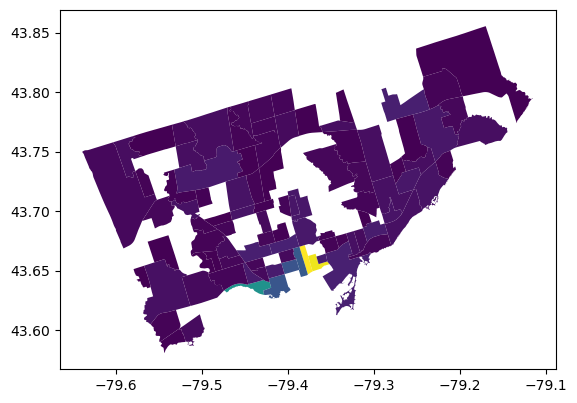

In [9]:
opioid_shp.plot(column='call_count')

In [10]:
clean_time['DA_area'] = [x.area for x in clean_time['geometry']]

In [12]:
clean_time

,wed_0800,sat_0900,wed_1100,wed_1500,DAUID,reg_name,area_km,pop,avg_inc,pop_nocar,low_inc,geometry,DA_area
0,0.0,0.0,-3.0,-1.0,35200002,Toronto,0.05037,356,79431.0,55.071330,25.0,"POLYGON ((-79.20270 43.82367, -79.20228 43.822...",0.000006
1,1.0,0.0,-3.0,-1.0,35200003,Toronto,0.04675,335,97695.0,0.000000,35.0,"POLYGON ((-79.20126 43.82041, -79.20080 43.819...",0.000005
2,0.0,0.0,-3.0,-2.0,35200004,Toronto,0.04878,384,66349.0,0.000000,40.0,"POLYGON ((-79.20522 43.81890, -79.20524 43.818...",0.000005
3,-1.0,0.0,-3.0,-1.0,35200005,Toronto,0.04429,408,97356.0,0.000000,25.0,"POLYGON ((-79.20414 43.81748, -79.20447 43.817...",0.000005
4,-1.0,0.0,-3.0,-1.0,35200006,Toronto,0.05717,527,80188.0,0.000000,40.0,"POLYGON ((-79.20335 43.81687, -79.20361 43.816...",0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,0.0,0.0,0.0,0.0,35204902,Toronto,0.01994,498,55037.0,321.265496,165.0,"POLYGON ((-79.38372 43.66124, -79.38584 43.660...",0.000002
3698,2.0,3.0,2.0,3.0,35204903,Toronto,0.63493,3495,48495.0,494.285900,1170.0,"POLYGON ((-79.37532 43.76559, -79.37546 43.765...",0.000071
3699,2.0,2.0,1.0,2.0,35204904,Toronto,0.08969,626,51243.0,292.351880,175.0,"POLYGON ((-79.37593 43.76551, -79.37609 43.765...",0.000010
3700,1.0,1.0,1.0,1.0,35204905,Toronto,1.08844,1774,50783.0,307.684076,525.0,"POLYGON ((-79.33724 43.76771, -79.33725 43.767...",0.000122


In [13]:
opioid_DAs = opioid_shp.overlay(clean_time)

In [14]:
opioid_DAs['overlay_area'] = [x.area for x in opioid_DAs['geometry']]

In [15]:
opioid_DAs = opioid_DAs[opioid_DAs['overlay_area'] >= opioid_DAs['DA_area'] * 0.9]

In [16]:
opioid_DAs.columns

Index(['#', 'neighbourhood', 'call_count', 'FIELD_1', 'FIELD_2', 'FIELD_3',
       'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_7', 'FIELD_8', 'FIELD_9',
       'FIELD_10', 'FIELD_11', 'call_pct', 'user_estimate', 'wed_0800',
       'sat_0900', 'wed_1100', 'wed_1500', 'DAUID', 'reg_name', 'area_km',
       'pop', 'avg_inc', 'pop_nocar', 'low_inc', 'DA_area', 'geometry',
       'overlay_area'],
      dtype='object')

In [17]:
neighbourhood_pops = opioid_DAs.groupby('FIELD_7')['pop'].sum().reset_index()
neighbourhood_pops.rename(columns={'pop':'neighbourhood_pop'}, inplace=True)
opioid_DAs = opioid_DAs.merge(neighbourhood_pops, on='FIELD_7')

In [18]:
opioid_DAs['DA_pop_pct'] = opioid_DAs['pop'] / opioid_DAs['neighbourhood_pop']

In [19]:
opioid_DAs['da_opioid_users'] = opioid_DAs['user_estimate'] * opioid_DAs['DA_pop_pct'] 

In [20]:
opioid_DAs['da_opioid_users'].sum()

122299.0

In [21]:
opioid_DAs

,#,neighbourhood,call_count,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,...,pop,avg_inc,pop_nocar,low_inc,DA_area,geometry,overlay_area,neighbourhood_pop,DA_pop_pct,da_opioid_users
0,1,Church-Yonge Corridor,498,48,2501239,26022434,None,75,75,Church-Yonge Corridor,...,637,64587.0,279.673182,110.0,0.000004,"POLYGON ((-79.37298 43.65305, -79.37283 43.652...",0.000004,31340,0.020325,380.313460
1,1,Church-Yonge Corridor,498,48,2501239,26022434,None,75,75,Church-Yonge Corridor,...,907,111754.0,286.386242,80.0,0.000008,"POLYGON ((-79.37237 43.65153, -79.37227 43.651...",0.000008,31340,0.028941,541.513827
2,1,Church-Yonge Corridor,498,48,2501239,26022434,None,75,75,Church-Yonge Corridor,...,2119,106370.0,901.099728,270.0,0.000020,"POLYGON ((-79.37386 43.64863, -79.37384 43.648...",0.000020,31340,0.067613,1265.124366
3,1,Church-Yonge Corridor,498,48,2501239,26022434,None,75,75,Church-Yonge Corridor,...,2527,60142.0,1764.640742,580.0,0.000005,"POLYGON ((-79.37991 43.66997, -79.37990 43.669...",0.000005,31340,0.080632,1508.716033
4,1,Church-Yonge Corridor,498,48,2501239,26022434,None,75,75,Church-Yonge Corridor,...,1612,57096.0,897.813626,370.0,0.000003,"POLYGON ((-79.37945 43.66889, -79.37945 43.668...",0.000003,31340,0.051436,962.425898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,97,Casa Loma,7,41,2501246,26022441,None,96,96,Casa Loma,...,331,340907.0,35.462886,50.0,0.000022,"POLYGON ((-79.40889 43.68152, -79.40796 43.681...",0.000022,9793,0.033800,8.889599
2594,97,Casa Loma,7,41,2501246,26022441,None,96,96,Casa Loma,...,393,268080.0,246.305692,50.0,0.000010,"POLYGON ((-79.40941 43.68056, -79.40902 43.679...",0.000010,9793,0.040131,10.554721
2595,97,Casa Loma,7,41,2501246,26022441,None,96,96,Casa Loma,...,749,146609.0,336.076899,105.0,0.000012,"POLYGON ((-79.41260 43.68667, -79.41259 43.686...",0.000012,9793,0.076483,20.115740
2596,97,Casa Loma,7,41,2501246,26022441,None,96,96,Casa Loma,...,483,312896.0,145.894142,40.0,0.000014,"POLYGON ((-79.41260 43.68669, -79.41282 43.687...",0.000014,9793,0.049321,12.971832


In [399]:
import matplotlib

In [404]:
from matplotlib.colors import LogNorm, Normalize

Index(['#', 'neighbourhood', 'call_count', 'FIELD_1', 'FIELD_2', 'FIELD_3',
       'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_7', 'FIELD_8', 'FIELD_9',
       'FIELD_10', 'FIELD_11', 'call_pct', 'user_estimate', 'wed_0800',
       'sat_0900', 'wed_1100', 'wed_1500', 'DAUID', 'reg_name', 'area_km',
       'pop', 'avg_inc', 'pop_nocar', 'low_inc', 'DA_area', 'geometry',
       'overlay_area', 'neighbourhood_pop', 'DA_pop_pct', 'da_opioid_users'],
      dtype='object')

<AxesSubplot: >

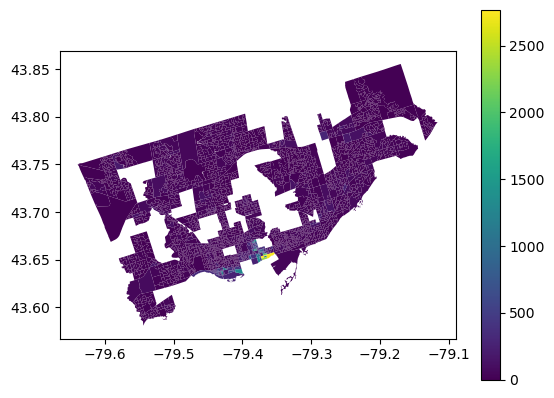

In [406]:
opioid_DAs.plot(column='da_opioid_users', legend=True)

In [410]:
for_export = opioid_DAs[['DAUID', 'da_opioid_users']]

In [414]:
for_export.to_csv(data_dir + 'da_users.csv')

In [413]:
for_export

,DAUID,da_opioid_users
0,35200821,380.313460
1,35200822,541.513827
2,35204022,1265.124366
3,35204578,1508.716033
4,35204579,962.425898
...,...,...
2593,35202809,8.889599
2594,35202810,10.554721
2595,35202880,20.115740
2596,35202881,12.971832


In [2]:
travel_times = gpd.read_file('/Users/shivyucel/Documents/projects/opioid_accessibility/opioid_accessibility/data/toronto_data/results/travel_time_diff/travel_time_diff_2.shp')

In [4]:
msdi = pd.read_excel(data_dir + 'deprivation_data/MSDI.xlsx', sheet_name='DATA')

/Users/shivyucel/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [7]:
full_table = clean_time.merge(msdi, left_on='DAUID', right_on='DA')

In [9]:
full_table.columns

Index(['wed_0800', 'sat_0900', 'wed_1100', 'wed_1500', 'DAUID', 'reg_name',
       'area_km', 'pop', 'avg_inc', 'pop_nocar', 'low_inc', 'geometry', 'DA',
       'DAPOP2016', 'MUNIC', 'PR', 'CR', 'CMA', 'ZONE', 'ZIM', 'SCOREMAT',
       'SCORESOC', 'QUINTMAT', 'QUINTSOC', 'CentMat', 'CentSoc', 'QUINTMATCR',
       'QUINTSOCCR', 'QUINTMATZONE', 'QUINTSOCZONE', 'QUINTMATCMA',
       'QUINTSOCCMA'],
      dtype='object')

In [61]:
full_table['mat_quant'] = pd.qcut(full_table['SCOREMAT'], 5, labels= [1,2,3,4,5])
full_table['soc_quant'] = pd.qcut(full_table['SCORESOC'], 5, labels= [1,2,3,4,5])
               

In [62]:
full_table['mat_quant'] = full_table.mat_quant.cat.codes + 1
full_table['soc_quant'] = full_table.soc_quant.cat.codes + 1

## 20-Minute Thresholds
### Wednesday 

In [66]:
thres_20 = travel

,fromId,toId_x,tt_2019,tt_2020,diff,GeoUID,neg_access,time,weekend,geometry
0,35180019,TrueNorth Medical Clinic - Oshawa - Taunton Ph...,105,97,-8,35180019,0,0800,0,"POLYGON ((-79.11900 44.10972, -79.12042 44.109..."
1,35180021,TrueNorth Medical Clinic - Oshawa - Taunton Ph...,102,95,-7,35180021,0,0800,0,"POLYGON ((-79.11652 44.10828, -79.11569 44.106..."
2,35180356,Methadone Oshawa - New Direction Addiction Clinic,37,42,5,35180356,1,0800,0,"POLYGON ((-78.99211 43.86013, -79.00002 43.858..."
3,35180357,Renew Medical Clinics - Ajax,31,36,5,35180357,1,0800,0,"POLYGON ((-79.01016 43.86410, -79.00981 43.863..."
4,35180358,Renew Medical Clinics - Ajax,31,37,6,35180358,1,0800,0,"POLYGON ((-79.01478 43.86079, -79.01443 43.859..."
...,...,...,...,...,...,...,...,...,...,...
27481,35240855,Oakville Treatment Centre,113,113,0,35240855,1,0900_sat,1,"POLYGON ((-79.76511 43.43554, -79.76516 43.435..."
27482,35240857,Oakville Treatment Centre,115,115,0,35240857,1,0900_sat,1,"POLYGON ((-79.76288 43.43230, -79.76244 43.431..."
27483,35240858,Oakville Treatment Centre,108,108,0,35240858,1,0900_sat,1,"POLYGON ((-79.75718 43.42870, -79.75745 43.428..."
27484,35240859,OATC Oakville Clinic,60,60,0,35240859,1,0900_sat,1,"POLYGON ((-79.70315 43.49644, -79.70300 43.495..."


In [63]:
full_table

,wed_0800,sat_0900,wed_1100,wed_1500,DAUID,reg_name,area_km,pop,avg_inc,pop_nocar,...,CentMat,CentSoc,QUINTMATCR,QUINTSOCCR,QUINTMATZONE,QUINTSOCZONE,QUINTMATCMA,QUINTSOCCMA,mat_quant,soc_quant
0,0.0,0.0,-3.0,-1.0,35200002,Toronto,0.05037,356,79431.0,55.071330,...,72.0,24.0,4.0,2.0,4.0,2.0,4.0,2.0,4,2
1,1.0,0.0,-3.0,-1.0,35200003,Toronto,0.04675,335,97695.0,0.000000,...,67.0,5.0,4.0,1.0,4.0,1.0,4.0,1.0,3,1
2,0.0,0.0,-3.0,-2.0,35200004,Toronto,0.04878,384,66349.0,0.000000,...,96.0,3.0,5.0,1.0,5.0,1.0,5.0,1.0,5,1
3,-1.0,0.0,-3.0,-1.0,35200005,Toronto,0.04429,408,97356.0,0.000000,...,96.0,4.0,5.0,1.0,5.0,1.0,5.0,1.0,5,1
4,-1.0,0.0,-3.0,-1.0,35200006,Toronto,0.05717,527,80188.0,0.000000,...,82.0,8.0,5.0,1.0,4.0,1.0,4.0,1.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,0.0,0.0,0.0,0.0,35204902,Toronto,0.01994,498,55037.0,321.265496,...,6.0,72.0,1.0,4.0,1.0,3.0,1.0,3.0,1,4
3698,2.0,3.0,2.0,3.0,35204903,Toronto,0.63493,3495,48495.0,494.285900,...,39.0,76.0,2.0,4.0,3.0,4.0,3.0,4.0,2,4
3699,2.0,2.0,1.0,2.0,35204904,Toronto,0.08969,626,51243.0,292.351880,...,58.0,79.0,3.0,4.0,3.0,4.0,3.0,5.0,3,4
3700,1.0,1.0,1.0,1.0,35204905,Toronto,1.08844,1774,50783.0,307.684076,...,12.0,96.0,1.0,5.0,1.0,5.0,1.0,5.0,2,5
